In [249]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import tensorflow_probability as tfp
import sys
sys.path.append('../../')

from utility.mnist_data import adversarial_data
import matplotlib.pyplot as plt


from synthetic_data_generator import MLR,meal_income,two_feature_uncertainty
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization
from keras.datasets import mnist
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import KFold
import tensorflow.keras.backend as K
from tensorflow.python.keras import backend
from tensorflow.keras.models import Model
import seaborn as sns
try:
    plt.style.use('rossidata')
except:
    sns.set_style("white")
    
import mediapy as media
from extra_keras_datasets import emnist
import pandas as pd
from scipy.stats import ttest_ind,kstest

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Building out MINST dataset
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten

In [161]:
import sys
sys.path.append('../../')

from utility.mnist_data.adversarial_data import MNIST_EMNIST,compute_dropout_uncertainty

data=MNIST_EMNIST()


INFO:root:Loading dataset = emnist


# Looking at data


In [104]:
# vanilla data
print('Training Data')
media.show_images(data.X_train[:10],columns=10,  border=True, height=100,cmap='plasma')
print('Adversarial Data')
media.show_images(data.X_holdout[:10],columns=10,  border=True, height=100,cmap='plasma')


Training Data


,,,,,,,,,


Adversarial Data


,,,,,,,,,


In [183]:
train_keys=data.revere_categorical(data.y_train)
holdout_keys=data.revere_categorical(data.y_holdout)
print('Training Data')
media.show_images(data.X_train[train_keys==9][:10],columns=10,  border=True, height=100,cmap='plasma')
print('Adversarial Data')
media.show_images(data.X_holdout[holdout_keys==3][:10],columns=10,  border=True, height=100,cmap='plasma')



Training Data


,,,,,,,,,


Adversarial Data


,,,,,,,,,


/Users/nicholas.rossi/miniconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


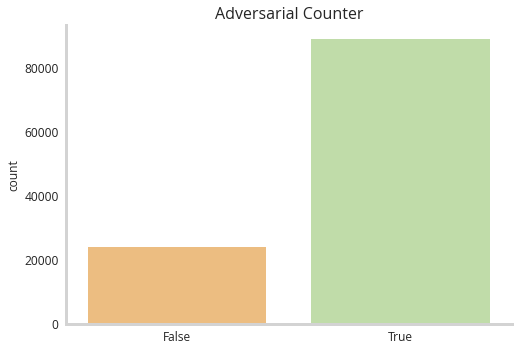

In [133]:
fig,ax=plt.subplots()
sns.countplot(holdout_keys>9,palette='Spectral',ax=ax)
ax.set_title('Adversarial Counter')
fig.savefig('figures/adv_count.png',bbox_inches='tight',dpi=300)


# Training Model and Testing Performance

In [150]:
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(32, kernel_size = 5, strides = 1, use_bias=False))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size = 3, strides = 1))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size = 3, strides = 1))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))


    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(10, activation='softmax'))
    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model



In [151]:
#scores, histories = evaluate_model(trainX, trainY)
# train model
model = define_model()
history = model.fit(data.X_train, data.y_train, epochs=10, batch_size=32, validation_data=(data.X_test, data.y_test), verbose=1)

Epoch 1/10
1875/1875 [==============================] - 83s 44ms/step - loss: 0.5676 - accuracy: 0.8250 - val_loss: 0.0981 - val_accuracy: 0.9723
Epoch 2/10
1875/1875 [==============================] - 98s 52ms/step - loss: 0.1335 - accuracy: 0.9631 - val_loss: 0.0599 - val_accuracy: 0.9817
Epoch 3/10
1875/1875 [==============================] - 91s 48ms/step - loss: 0.1186 - accuracy: 0.9675 - val_loss: 0.0373 - val_accuracy: 0.9889
Epoch 4/10
1875/1875 [==============================] - 86s 46ms/step - loss: 0.0975 - accuracy: 0.9737 - val_loss: 0.0841 - val_accuracy: 0.9784
Epoch 5/10
1875/1875 [==============================] - 85s 45ms/step - loss: 0.0988 - accuracy: 0.9734 - val_loss: 0.0425 - val_accuracy: 0.9882
Epoch 6/10
1875/1875 [==============================] - 91s 49ms/step - loss: 0.0847 - accuracy: 0.9754 - val_loss: 0.0409 - val_accuracy: 0.9884
Epoch 7/10
1875/1875 [==============================] - 88s 47ms/step - loss: 0.0807 - accuracy: 0.9783 - val_loss: 0.0354 -

In [204]:
# Testing
N_samples=data.X_holdout[holdout_keys==23]
# print(len(N_samples))
# threes_samples=data.X_holdout[holdout_keys==3]
# print(len(threes_samples))

N_dropout_means,N_dropout_uncertainy,N_result=compute_dropout_uncertainty(model,N_samples)

Text(0.5, 1.0, 'N std predictions')

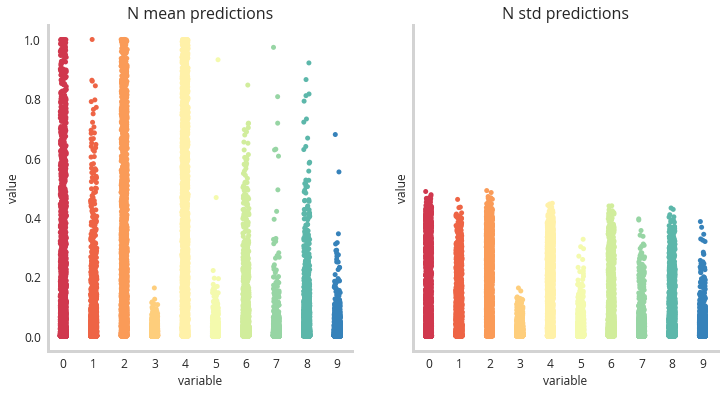

In [205]:
fig,ax=plt.subplots(1,2,figsize=(12,6),sharex=True,sharey=True)

sns.stripplot(x='variable',y='value',data=pd.DataFrame(N_dropout_means).melt(),palette='Spectral',ax=ax[0])
sns.stripplot(x='variable',y='value',data=pd.DataFrame(N_dropout_uncertainy).melt(),palette='Spectral',ax=ax[1])
ax[0].set_title('N mean predictions')
ax[1].set_title('N std predictions')

In [206]:
# Testing

threes_samples=data.X_holdout[holdout_keys==3]
# print(len(threes_samples))

three_dropout_means,three_dropout_uncertainy,three_result=compute_dropout_uncertainty(model,threes_samples)

Text(0.5, 1.0, '3 std predictions')

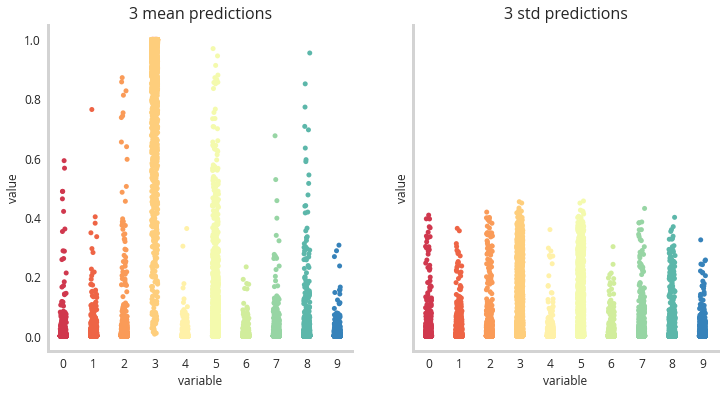

In [207]:
fig,ax=plt.subplots(1,2,figsize=(12,6),sharex=True,sharey=True)

sns.stripplot(x='variable',y='value',data=pd.DataFrame(three_dropout_means).melt(),palette='Spectral',ax=ax[0])
sns.stripplot(x='variable',y='value',data=pd.DataFrame(three_dropout_uncertainy).melt(),palette='Spectral',ax=ax[1])
ax[0].set_title('3 mean predictions')
ax[1].set_title('3 std predictions')

<AxesSubplot:xlabel='value', ylabel='variable'>

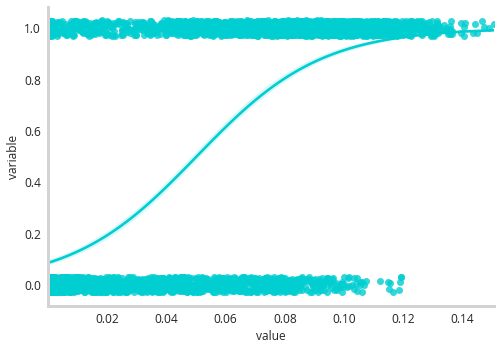

In [215]:
subset=pd.DataFrame({0:np.mean(three_dropout_uncertainy,axis=1),1:np.mean(N_dropout_uncertainy,axis=1)}).melt()

sns.regplot(x="value", y="variable", data=subset,
                 logistic=True, n_boot=500, y_jitter=.03)

# Comparing Models:


In [231]:
from utility.mnist_data.model_warehouse import *


In [ ]:
fig,ax=plt.subplots(1,2,figsize=(12,4),sharex=True)
labels=['normal','high_dropout']
meta_metrics={}

roc_fig,roc_ax=plt.subplots(figsize=(5,5))

for i,model_type in enumerate([basic_CNN,basic_CNN_high_dropout]):
    metrics={}
    model = model_type()
    history = model.fit(data.X_train, data.y_train, epochs=2, batch_size=32, validation_data=(data.X_test, data.y_test), verbose=1)
    
    N_dropout_means,N_dropout_uncertainy,N_result=compute_dropout_uncertainty(model,N_samples)
    three_dropout_means,three_dropout_uncertainy,three_result=compute_dropout_uncertainty(model,threes_samples)
    subset=pd.DataFrame({0:np.mean(three_dropout_uncertainy,axis=1),1:np.mean(N_dropout_uncertainy,axis=1)}).melt()

    N_values=np.mean(N_dropout_uncertainy,axis=1)
    three_values=np.mean(three_dropout_uncertainy,axis=1)
    N_mean=np.round(np.mean(N_dropout_uncertainy),2)
    three_mean=np.round(np.mean(three_dropout_uncertainy),2)
    
    metrics['k_metric']=kstest(N_values,three_values)[0]
    
    metrics['diff_means']=N_mean-three_mean

    print(f'{labels[i]}, n uq : {N_mean}, 3 uq :{three_mean}')
    
    sns.regplot(x="value", y="variable", data=subset,
                     logistic=True,
                n_boot=500, y_jitter=.03,scatter_kws={'alpha':0.05},ax=ax[i])
    
    ax[i].set_title(labels[i])
    ax[i].set_xlabel('Uncertainty')
    ax[i].set_yticks([0,1])
    ax[i].set_yticklabels(['3','N'])
    
    
    ### computing logistic regression
    ground=subset['variable'].values
    clf = LogisticRegression(random_state=0).fit(subset['value'].values.reshape(-1,1), ground)
    predictions=clf.predict_proba(subset['value'].values.reshape(-1,1))[:,1]
    fpr, tpr, _ = roc_curve(ground, predictions)
    roc_auc = auc(fpr, tpr)
    metrics['AUC']=roc_auc
    meta_metrics[labels[i]]=metrics

    roc_ax.plot(fpr, tpr, 
         lw=3, label=f'{labels[i]} {np.round(roc_auc,2)}')

roc_ax.plot([0,1],[0,1],color='#d3d3d3',linewidth=3)
roc_ax.set_xlabel('False Positive Rate')
roc_ax.set_ylabel('True Positive Rate')
roc_ax.set_title(f'ROC curve' )
roc_ax.legend()

    
fig.savefig('figures/dropout_gauntlet_model.png',dpi=300,bbox_inches='tight')
    

Epoch 1/2
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3414 - accuracy: 0.8926 - val_loss: 0.0636 - val_accuracy: 0.9791
Epoch 2/2
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0741 - accuracy: 0.9771 - val_loss: 0.0475 - val_accuracy: 0.9840
normal, n uq : 0.05000000074505806, 3 uq :0.009999999776482582
Epoch 1/2
1875/1875 [==============================] - 19s 10ms/step - loss: 0.6971 - accuracy: 0.7802 - val_loss: 0.1199 - val_accuracy: 0.9691
Epoch 2/2
1875/1875 [==============================] - 19s 10ms/step - loss: 0.2182 - accuracy: 0.9347 - val_loss: 0.0802 - val_accuracy: 0.9786


In [ ]:
# Computing classifier for adversarial /non-adversarial

In [238]:
from sklearn.linear_model import LogisticRegression

In [247]:
clf = LogisticRegression(random_state=0).fit(subset['value'].values.reshape(-1,1), subset['variable'].values)

In [260]:

predictions=clf.predict_proba(subset['value'].values.reshape(-1,1))[:,1]
ground=subset['variable'].values

Text(0.5, 1.0, 'ROC curve (AUC = 0.84)')

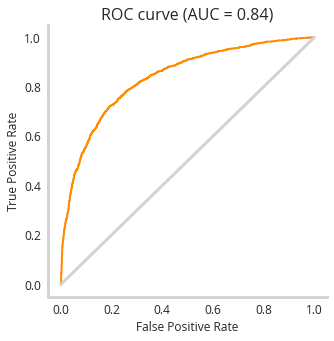

In [267]:

fpr, tpr, _ = roc_curve(ground, predictions)
roc_auc = auc(fpr, tpr)

lw = 2
# plt.figure()

fig,ax=plt.subplots(figsize=(5,5))

ax.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)

ax.plot([0,1],[0,1],color='#d3d3d3',linewidth=3)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(f'ROC curve (AUC = {np.round(roc_auc,2)})' )

In [73]:
(input_train, target_train), (input_test, target_test) = emnist.load_data(type='balanced')


INFO:root:Loading dataset = emnist


743907328/743900280 [==============================] - 36s 0us/step


In [74]:

media.show_images(input_train[:6],columns=6,  border=True, height=100,cmap='plasma')

,,,,,


In [6]:

# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model



In [8]:
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories



In [18]:
trainX, trainY, testX, testY = load_dataset()
trainX, testX = prep_pixels(trainX, testX)


In [24]:
#scores, histories = evaluate_model(trainX, trainY)
# train model
model = define_model()
trainX, trainY, testX, testY = load_dataset()
trainX, testX = prep_pixels(trainX, testX)
history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)

In [58]:


partial_model = Model(model.inputs, model.layers[-1].output)
result = []
n_iter=10
for i in range(n_iter):
    result.append(partial_model(testX))

result = np.array(result)

prediction_mean = result.mean(axis=0)
prediction_std=result.std(axis=0)
        


In [65]:


prediction_mean = result.mean(axis=0)
prediction_std=result.std(axis=0)
        

In [67]:
prediction_std[0]

array([6.7762636e-21, 5.5511151e-17, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 6.9388939e-18], dtype=float32)

In [57]:
testX.shape

(10000, 28, 28, 1)

In [39]:
testX[0].shape

(28, 28, 1)

In [75]:
X, y= emnist.load_data()


INFO:root:Loading dataset = emnist


In [77]:
y

(array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        ...,
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],